# Estimation de la latence et de la capacité d’une connexion à partir de mesures asymétriques

Ce document correspond au Sujet 4 du module 3 du MOOC "Recherche reproductible : principes méthodologiques pour une science transparente".

On s'intéresse à comparer un modèle simple de la performance d'une connexion de réseau avec des données réelles.

In [1]:
%matplotlib inline

import os
from os.path import exists
import requests
import gzip

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

## Téléchargement des données

On s'intéresse à deux jeux de données hébergés en ligne. La première étape est de les télécharger en local.

In [2]:
# Noms des fichiers en local
filenames = [
    "liglab2.log", 
    "stackoverflow.log",
]
# Adresse où les fichiers sont hébergés
urls = [
    "http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/liglab2.log.gz",
    "http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/stackoverflow.log.gz",
]

In [3]:
# Si les fichiers n'existent pas encore, on les télécharge.

def download_archive(filename, url):
    if not exists(filename):
        # On utilise le module requests pour récupérer les données en ligne
        archive = requests.get(url)
        # Le fichier est une archive .gz, on l'extrait avec le module gzip
        content = gzip.decompress(archive.content)
        
        open(filename,'wb').write(content)
        print(f"Téléchargement de {url} et extraction vers {filename}.")
    else:
        print(f"Le fichier {filename} existe déjà, pas besoin de le télécharger.")


for filename, url in zip(filenames, urls):
    download_archive(filename, url)


Le fichier liglab2.log existe déjà, pas besoin de le télécharger.
Le fichier stackoverflow.log existe déjà, pas besoin de le télécharger.


## Lecture des données
On extrait maintenant les données de l'outil `ping` sous forme d'un tableau `pandas`.

Le format étant relativement simple, il est possible de le faire en utilisant uniquement les fonctions de base des chaînes de caractères de Python.

Chaque ligne a la forme suivante:
```
[1421761682.052172] 665 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=22.5 ms
```
On extrait uniquement les données qui nous intéressent :

 * la date de mesure (en secondes depuis le 1er janvier 1970) du 2e au 18e caractère
 * la taille du message (en octets), qui est suivi de la sous-chaîne `" bytes"`
 * la durée de réponse (en millisecondes), qui est précédé de `"time="` et suivi de `" ms"`

In [4]:
def extract_data(filename):
    timestamps = []
    msgsizes = []
    times = []
    err_count = 0
    success_count = 0
    
    with open(filename, 'r') as file:
        for line in file.readlines():
            try:
                # Date de mesure (timestamp)
                # du caractère n°1 au n°17 inclus (numérotés à partir de 0)
                ts_str = line[1:18]
                ts_float = float(ts_str)
                # On convertit en date pandas
                ts = pd.Timestamp(ts_float, unit='s')

                # Taille du message (message size)
                ms_str = line[20:line.index(" bytes")]
                ms_int = int(ms_str)

                # Durée de l'échange (time)
                time_str = line[line.index('time=')+5:line.rindex(" ms")]
                time_float = float(time_str)
                
                # Une fois les valeurs trouvées, on les ajoute au tableau
                timestamps.append(ts)
                msgsizes.append(ms_int)
                times.append(time_float)
                success_count += 1
                
            except ValueError:
                # Lorsqu'il manque l'une des valeurs, on oublie la ligne correspondante
                err_count += 1
           
    total_count = success_count + err_count
    print(f"{success_count} lignes lues avec succès ({100*err_count/total_count:.2f}% d'échecs)")
    return pd.DataFrame({"timestamp":timestamps, "msgsize":msgsizes, "time":times})
    

data0 = extract_data(filenames[0])

data0

44036 lignes lues avec succès (0.85% d'échecs)


msgsize   time                  timestamp
0          665  22.50 2015-01-20 13:48:02.052172
1         1373  21.20 2015-01-20 13:48:02.277315
2          262  21.20 2015-01-20 13:48:02.502054
3         1107  23.30 2015-01-20 13:48:02.729257
4         1128   1.41 2015-01-20 13:48:02.934648
5          489  21.90 2015-01-20 13:48:03.160397
6         1759  78.70 2015-01-20 13:48:03.443055
7         1146  25.10 2015-01-20 13:48:03.672157
8          884  24.00 2015-01-20 13:48:03.899933
9         1422  19.50 2015-01-20 13:48:04.122687
10        1180  18.00 2015-01-20 13:48:04.344135
11         999  18.80 2015-01-20 13:48:04.566271
12        1020  24.30 2015-01-20 13:48:04.998504
13          71   3.45 2015-01-20 13:48:05.205172
14          34   5.85 2015-01-20 13:48:05.414106
15        1843   2.31 2015-01-20 13:48:05.620117
16         407   1.14 2015-01-20 13:48:05.824949
17         356   1.10 2015-01-20 13:48:06.029177
18        1511   2.18 2015-01-20 13:48:06.234464
19         587   1.27 2015-01-20 13:48:06.438772
20         809   1.33 2015-01-20 13:48:06.643208
21        1364   1.51 2015-01-20 13:48:06.848323
22        1153   1.44 2015-01-20 13:48:07.053400
23         853   1.30 2015-01-20 13:48:07.257704
24        1510   2.17 2015-01-20 13:48:07.463275
25         123   1.21 2015-01-20 13:48:07.668423
26        1966   2.20 2015-01-20 13:48:07.874230
27         933   1.34 2015-01-20 13:48:08.078667
28         922   1.42 2015-01-20 13:48:08.283655
29          24   1.12 2015-01-20 13:48:08.488688
...        ...    ...                        ...
44006     1772  28.80 2015-01-20 16:26:20.743715
44007       41   1.14 2015-01-20 16:26:20.949053
44008     1944   2.32 2015-01-20 16:26:21.155685
44009      400   1.98 2015-01-20 16:26:21.362095
44010      226   3.01 2015-01-20 16:26:21.569409
44011      466   7.45 2015-01-20 16:26:21.780805
44012      350  13.50 2015-01-20 16:26:21.998869
44013     1829  45.90 2015-01-20 16:26:22.248969
44014     1954  58.50 2015-01-20 16:26:22.512386
44015     1074   1.45 2015-01-20 16:26:22.717961
44016       46   1.11 2015-01-20 16:26:22.923292
44017     1844   2.26 2015-01-20 16:26:23.129965
44018      645   1.24 2015-01-20 16:26:23.335449
44019      444   1.25 2015-01-20 16:26:23.540901
44020     1940   2.46 2015-01-20 16:26:23.747983
44021     1411   1.47 2015-01-20 16:26:23.954099
44022       49   1.21 2015-01-20 16:26:24.159879
44023      420   1.55 2015-01-20 16:26:24.365815
44024      227   1.22 2015-01-20 16:26:24.571516
44025      947   1.34 2015-01-20 16:26:24.777325
44026     1960   2.43 2015-01-20 16:26:24.983905
44027      531   1.19 2015-01-20 16:26:25.188976
44028      374   1.14 2015-01-20 16:26:25.394275
44029     1503   2.19 2015-01-20 16:26:25.600745
44030      572   1.29 2015-01-20 16:26:25.805877
44031     1338   1.47 2015-01-20 16:26:26.011910
44032     1515   7.02 2015-01-20 16:26:26.222729
44033     1875   2.33 2015-01-20 16:26:26.429007
44034     1006   1.61 2015-01-20 16:26:26.634747
44035     1273   1.35 2015-01-20 16:26:26.840222

[44036 rows x 3 columns]

## 1. Evolution du temps de transmission au cours du temps

Affichons l'évolution du temps de transmission, afin de voir si celui ci est corrélé avec la taille des messages.

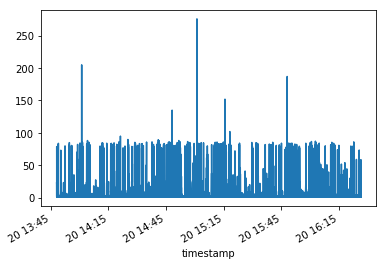

In [5]:
sequence = data0.set_index("timestamp").sort_index()

sequence['time'].plot()

Les données ont de fortes variations, restreignons l'aperçu à un intervalle de temps plus restreint.

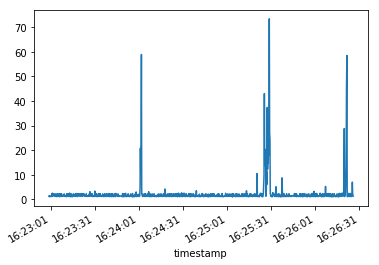

In [6]:
sequence['time'][-1000:].plot()

On observe une grande variabilité dans les temps de réponse : souvent ils sont très brefs, mais parfois il y a des pics de lenteur.
Comparons cela à la taille des données sur le même intervalle, afin de voir si cela s'explique par la taille des messages.

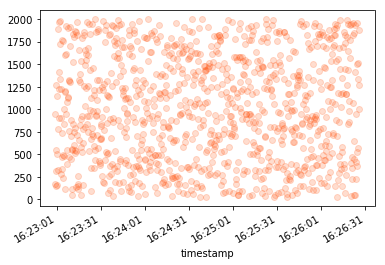

In [7]:
sequence["msgsize"][-1000:].plot(linewidth=0,marker='o',color='#ff551133')

La répartition des tailles de messages est la même sur tout l'intervalle de temps considéré. Il ne semble donc pas y avoir de lien direct entre de très longs temps de réponse et les tailles de messages.

## 2. Temps de transmission en fonction de la taille des messages

Représentons le temps de transmission en fonction de la taille des messages.

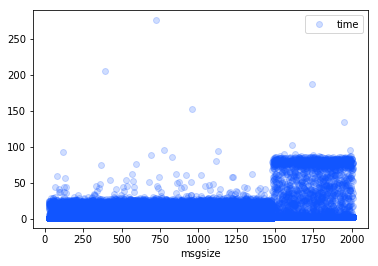

In [8]:
data0.plot('msgsize','time',linewidth=0,marker='o',color='#1155ff33')

On observe deux zones distinctes : à partir d'une certaine taille de messages, la répartition des temps de réponse change drastiquement.
Zoomons pour voir où cette rupture se situe.

(0, 100)

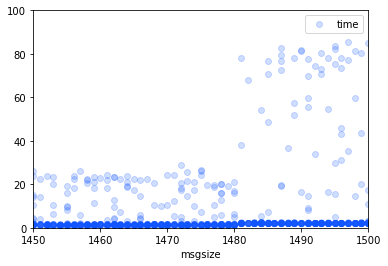

In [9]:
data0.plot('msgsize','time',linewidth=0,marker='o',color='#1155ff33')
plt.xlim((1450,1500))
plt.ylim((0,100))

Ce graphique apporte deux informations de plus par rapport au précédent :

 * la rupture se situe entre 1480 et 1481 octets
 * le temps de réponse est le plus souvent très faible (<10ms) quelle que soit la taille du message, mais il y a régulièrement des valeurs plus élevées (jusqu'à 30ms pour la première zone, ou 100ms pour la deuxième).
 
Séparons les données en deux sous-jeux selon la taille de message.

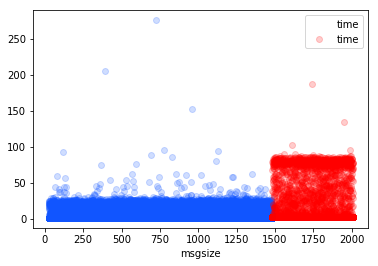

In [10]:
petits_msg = data0[data0['msgsize']<=1480]
gros_msg = data0[data0['msgsize']>1480]

fig,ax = plt.subplots(1)
petits_msg.plot('msgsize','time',ax=ax, linewidth=0,marker='o',color='#1155ff33')
gros_msg.plot('msgsize','time',ax=ax, linewidth=0,marker='o',color='#ff000033')

## 2.1 (Non demandé) Histogramme des temps de transmission

La répartition des temps de transmission étant très inégale, représentons la répartition des temps de réponse sous forme d'histogramme (pour les deux zones de taille de message).
On choisit de découper les zones selon les déciles, et d'utiliser une échelle logarithmique en x.

[]

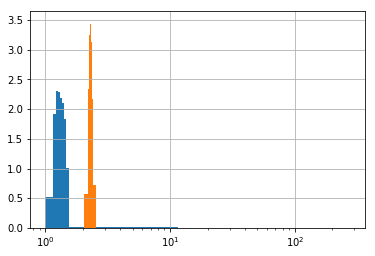

In [11]:
bins_p = petits_msg["time"].quantile(np.linspace(0,1,11))
bins_g = gros_msg["time"].quantile(np.linspace(0,1,11))

fig,ax = plt.subplots(1)
petits_msg["time"].hist(bins=bins_p,density=True,ax=ax)
gros_msg["time"].hist(bins=bins_g,density=True,ax=ax)
plt.semilogx()

En particulier, la médiane des temps de transmission sur chaque sous-jeu de données est :

In [12]:
print("Médiane des temps pour les petits messages :",petits_msg["time"].quantile(0.5),"ms")
print("Médiane des temps pour les gros messages :",gros_msg["time"].quantile(0.5),"ms")

Médiane des temps pour les petits messages : 1.35 ms
Médiane des temps pour les gros messages : 2.32 ms


## 3. Régression linéaire
D'après l'énoncé :

> Un modèle simple et fréquemment utilisé pour décrire la performance d'une connexion de réseau consiste à supposer que le temps d'envoi T pour un message dépend principalement de sa taille S (nombre d'octets) et de deux grandeurs propres à la connexion : la latence L (en secondes) et la capacité C (en octets/seconde). La relation entre ces quatre quantités est T(S) = L + S/C.

Cherchons L et C pour chaque partie du jeu de données.

In [13]:
def linreg(dataset):
    X = np.array(dataset["msgsize"])
    Y = np.array(dataset["time"])
    
    X = X.reshape(len(X),1) # On utilise une matrice car c'est requis par sklearn
    Y = Y.reshape(len(X),1)
    
    # Régression linéaire : on trouve a et b tels que T = a*S + b
    lm = LinearRegression()
    fit = lm.fit(X,Y)
    rsquare = lm.score(X,Y)
    return fit, rsquare

lreg_p, rsquare_p = linreg(petits_msg)
lreg_g, rsquare_g = linreg(gros_msg)

# Estimation de la latence et de la capacité
# On a L = b et C = 1/a
lat_p = float(lreg_p.intercept_)
cap_p = 1/float(lreg_p.coef_)

lat_g = float(lreg_g.intercept_)
cap_g = 1/float(lreg_g.coef_)

In [14]:
print("Petits messages")
print(f"Latence:{lat_p} ; capacité:{cap_p} ; R²={rsquare_p}")
print("Gros messages")
print(f"Latence:{lat_g} ; capacité:{cap_g} ; R²={rsquare_g}")

Petits messages
Latence:3.275674199393943 ; capacité:3064.5146168986353 ; R²=0.0004513532467899095
Gros messages
Latence:5.289832573707132 ; capacité:387.76039978488814 ; R²=0.00035615827070534234


On constate que le coefficient de régression R² est très faible, ce qui signifie que la corrélation n'est pas significative. Affichons cependant le résultat de la régression.

(0, 110)

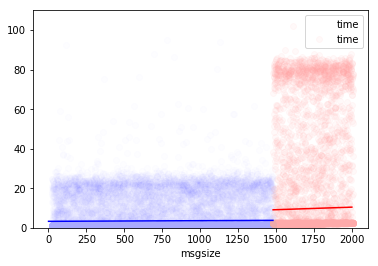

In [15]:
fig,ax = plt.subplots(1)
# La même figure qu'avant : durée de réponse en fonction de la taille du message
# Petits messages en bleu pâle
petits_msg.plot('msgsize','time',ax=ax, linewidth=0,marker='o',color='#aaaaff05')
# Gros messages en rouge pâle
gros_msg.plot('msgsize','time',ax=ax, linewidth=0,marker='o',color='#ffaaaa11')

# Résultat de la régression
# Petits messages
xx_p = np.linspace(1,1480)
yy_p = lat_p + xx_p/cap_p
plt.plot(xx_p, yy_p, color="#0000ff")

# Gros messages
xx_g = np.linspace(1481,2000)
yy_g = lat_g + xx_g/cap_g
plt.plot(xx_g, yy_g, color="#ff0000")

plt.ylim((0,110))

On voit que cette régression ne correspond pas vraiment à une durée réelle : elle donne un temps supérieur à celui de la plupart des messages, mais qui tente de prendre en compte la moyenne générale.

# 4. Caractérisation du plus petit temps de transmission

La régression linéaire sur l'ensemble des données n'étant pas pertinente, on choisit d'étudier le plus petit temps de transmission pour un message d'une taille donnée.

In [16]:
# Extraction des plus petits temps de transmission à taille de message donnée

tmins = []
sizes = []
for size, subdata in data0.groupby("msgsize"):
    tmin = min(subdata['time'])
    tmins.append(tmin)
    sizes.append(size)

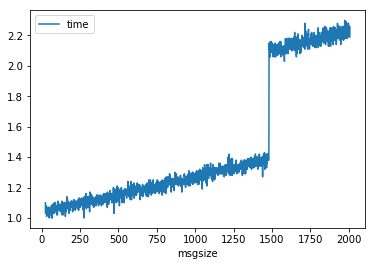

In [17]:
shorttimes = pd.DataFrame({"msgsize":sizes, "time":tmins})

shorttimes.plot("msgsize","time")

On observe quelque chose d'à peu près linéaire, en deux morceaux : c'est prometteur ! Séparons en deux et effectuons la régression linéaire.

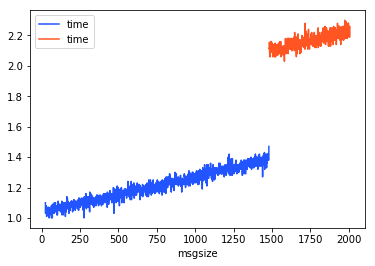

In [18]:
shortt_p = shorttimes[shorttimes['msgsize']<=1480]
shortt_g = shorttimes[shorttimes['msgsize']>1480]

fig,ax = plt.subplots()
shortt_p.plot("msgsize","time",color="#2255ff",ax=ax)
shortt_g.plot("msgsize","time",color="#ff5522",ax=ax)

In [19]:

lreg_p, rsquare_p = linreg(shortt_p)
lreg_g, rsquare_g = linreg(shortt_g)

# Estimation de la latence et de la capacité
# On a L = b et C = 1/a
lat_p = float(lreg_p.intercept_)
cap_p = 1/float(lreg_p.coef_)

lat_g = float(lreg_g.intercept_)
cap_g = 1/float(lreg_g.coef_)
print("Petits messages")
print(f"Latence:{lat_p} ; capacité:{cap_p} ; R²={rsquare_p}")
print("Gros messages")
print(f"Latence:{lat_g} ; capacité:{cap_g} ; R²={rsquare_g}")

Petits messages
Latence:1.0333934773971378 ; capacité:4217.8932227104215 ; R²=0.9401281379667491
Gros messages
Latence:1.7432379013400792 ; capacité:4133.823644047976 ; R²=0.5818125259942575


Cette fois les coefficients de régression sont cohérents !
Superposons le résultat de la régression linéaire au graphe précédent.

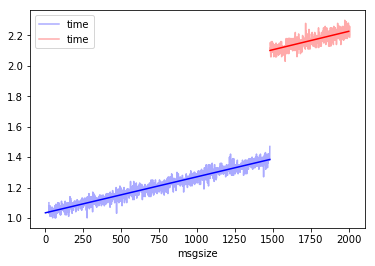

In [20]:
fig,ax = plt.subplots(1)
# La même figure qu'avant : durée de réponse en fonction de la taille du message
# Petits messages en bleu pâle
shortt_p.plot('msgsize','time',ax=ax,color='#aaaaff')
# Gros messages en rouge pâle
shortt_g.plot('msgsize','time',ax=ax,color='#ffaaaa')

# Résultat de la régression
# Petits messages
xx_p = np.linspace(1,1480)
yy_p = lat_p + xx_p/cap_p
plt.plot(xx_p, yy_p, color="#0000ff")

# Gros messages
xx_g = np.linspace(1481,2000)
yy_g = lat_g + xx_g/cap_g
plt.plot(xx_g, yy_g, color="#ff0000")

## 5. Travail sur le jeu de données de stackoverflow

Effectuons la même analyse sur les données de stackoverflow.

In [21]:
data0 = extract_data(filenames[1])

6824 lignes lues avec succès (0.91% d'échecs)


Le jeu de données est de taille plus réduite que le précédent, certainement pour des raisons pratiques (l'échange de données avec un serveur distant prend plus de temps).

### Evolution en temps

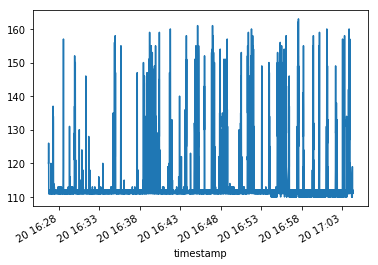

In [22]:
sequence = data0.set_index("timestamp").sort_index()

sequence['time'].plot()

On observe que les temps de transmission sont plus élevés (110 à 170 ms), et semblent plus instables que dans le cas du réseau local.

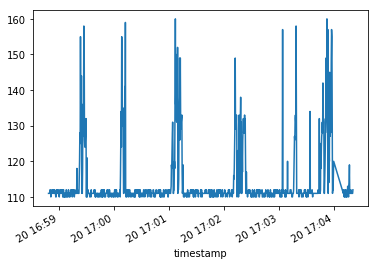

In [23]:
sequence['time'][-1000:].plot()

Comme sur le jeu de données précédent, il y a régulièrement des pics de latence.

### Temps de transmission en fonction de la taille

Représentons le temps de transmission en fonction de la taille des messages.

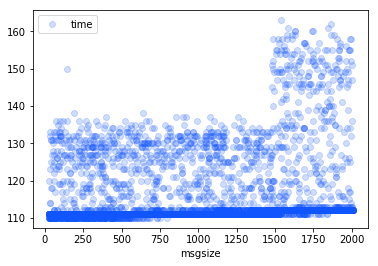

In [24]:
data0.plot('msgsize','time',linewidth=0,marker='o',color='#1155ff33')

Comme auparavent, on observe une rupture. Vérifions si elle est au même endroit.

(110, 120)

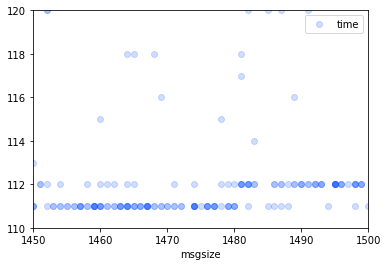

In [25]:
data0.plot('msgsize','time',linewidth=0,marker='o',color='#1155ff33')
plt.xlim((1450,1500))
plt.ylim((110,120))

La rupture est moins nette que dans le cas précédent, mais il est cohérent de continuer à séparer les messages en "petits" (taille <= 1480 octets) et "gros" (>1480 octets).

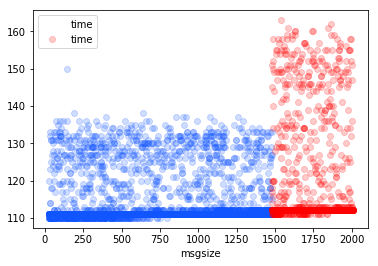

In [26]:
petits_msg = data0[data0['msgsize']<=1480]
gros_msg = data0[data0['msgsize']>1480]

fig,ax = plt.subplots(1)
petits_msg.plot('msgsize','time',ax=ax, linewidth=0,marker='o',color='#1155ff33')
gros_msg.plot('msgsize','time',ax=ax, linewidth=0,marker='o',color='#ff000033')

### Régression linéaire

On utilise la fonction définie précédemment.

In [27]:
lreg_p, rsquare_p = linreg(petits_msg)
lreg_g, rsquare_g = linreg(gros_msg)

# Estimation de la latence et de la capacité
# On a L = b et C = 1/a
lat_p = float(lreg_p.intercept_)
cap_p = 1/float(lreg_p.coef_)

lat_g = float(lreg_g.intercept_)
cap_g = 1/float(lreg_g.coef_)

print("Petits messages")
print(f"Latence:{lat_p} ; capacité:{cap_p} ; R²={rsquare_p}")
print("Gros messages")
print(f"Latence:{lat_g} ; capacité:{cap_g} ; R²={rsquare_g}")

Petits messages
Latence:113.22750968484877 ; capacité:22119.029139894385 ; R²=1.0854974891949531e-05
Gros messages
Latence:120.05358833473095 ; capacité:-554.6631211596176 ; R²=0.0005386609060091807


On trouve une capacité négative pour les "gros" messages : c'est incohérent.
Comme dans le cas précédent, les coefficients de régression R² sont très faibles.
Représentons les courbes de régression avec les données.

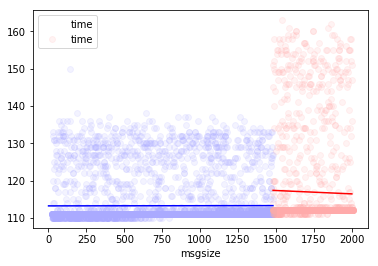

In [28]:
fig,ax = plt.subplots(1)
# La même figure qu'avant : durée de réponse en fonction de la taille du message
# Petits messages en bleu pâle
petits_msg.plot('msgsize','time',ax=ax, linewidth=0,marker='o',color='#aaaaff22')
# Gros messages en rouge pâle
gros_msg.plot('msgsize','time',ax=ax, linewidth=0,marker='o',color='#ffaaaa22')

# Résultat de la régression
# Petits messages
xx_p = np.linspace(1,1480)
yy_p = lat_p + xx_p/cap_p
plt.plot(xx_p, yy_p, color="#0000ff")

# Gros messages
xx_g = np.linspace(1481,2000)
yy_g = lat_g + xx_g/cap_g
plt.plot(xx_g, yy_g, color="#ff0000")


Comme on s'y attendait, la correspondance entre données et courbe de régression est assez mauvaise.

### Régression du plus petit temps de transmission

De la même façon que précédemment, on s'intéresse au plus petit temps de transmission pour chaque taille de message.

In [29]:
# Extraction des plus petits temps de transmission à taille de message donnée

tmins = []
sizes = []
for size, subdata in data0.groupby("msgsize"):
    tmin = min(subdata['time'])
    tmins.append(tmin)
    sizes.append(size)

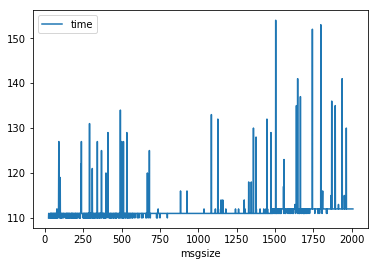

In [30]:
shorttimes = pd.DataFrame({"msgsize":sizes, "time":tmins})

shorttimes.plot("msgsize","time")

Alors que précédemment le plus petit temps de transmission était une donnée presque linéaire, cette fois elle est très bruitée. Par ailleurs on n'observe pas de distinction claire entre les petits et les gros messages.

Appliquons les mêmes calculs qu'avant pour trouver la latence et la capacité du réseau.

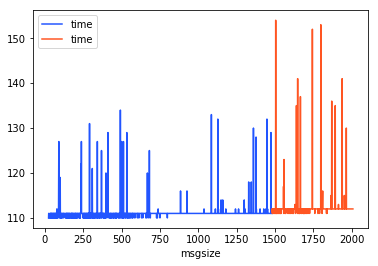

In [31]:
shortt_p = shorttimes[shorttimes['msgsize']<=1480]
shortt_g = shorttimes[shorttimes['msgsize']>1480]

fig,ax = plt.subplots()
shortt_p.plot("msgsize","time",color="#2255ff",ax=ax)
shortt_g.plot("msgsize","time",color="#ff5522",ax=ax)

In [32]:

lreg_p, rsquare_p = linreg(shortt_p)
lreg_g, rsquare_g = linreg(shortt_g)

# Estimation de la latence et de la capacité
# On a L = b et C = 1/a
lat_p = float(lreg_p.intercept_)
cap_p = 1/float(lreg_p.coef_)

lat_g = float(lreg_g.intercept_)
cap_g = 1/float(lreg_g.coef_)
print("Petits messages")
print(f"Latence:{lat_p} ; capacité:{cap_p} ; R²={rsquare_p}")
print("Gros messages")
print(f"Latence:{lat_g} ; capacité:{cap_g} ; R²={rsquare_g}")

Petits messages
Latence:110.88100305194719 ; capacité:2831.9221660729295 ; R²=0.004898770828737797
Gros messages
Latence:111.27277580312676 ; capacité:1410.9194353229204 ; R²=0.000613784644400095


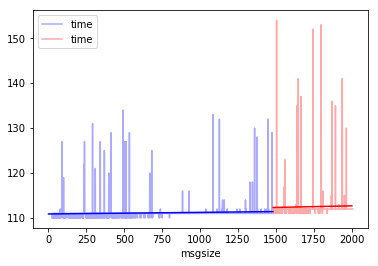

In [33]:
fig,ax = plt.subplots(1)
# La même figure qu'avant : durée de réponse en fonction de la taille du message
# Petits messages en bleu pâle
shortt_p.plot('msgsize','time',ax=ax,color='#aaaaff')
# Gros messages en rouge pâle
shortt_g.plot('msgsize','time',ax=ax,color='#ffaaaa')

# Résultat de la régression
# Petits messages
xx_p = np.linspace(1,1480)
yy_p = lat_p + xx_p/cap_p
plt.plot(xx_p, yy_p, color="#0000ff")

# Gros messages
xx_g = np.linspace(1481,2000)
yy_g = lat_g + xx_g/cap_g
plt.plot(xx_g, yy_g, color="#ff0000")

Les courbes suivent à peu près les données, mais les coefficients de régression sont mauvais : c'est probablement dû au bruit dans les données de temps les plus courts.

### Débruitage 

Afin de réduire le bruit, éliminons les données qui correspondent à un très faible nombre de mesures.

Combien de mesures par valeur de taille de message a-t-on environ ?

(array([589., 458., 345., 235., 158.,  83.,  25.,  18.,   2.,   3.]),
 array([ 3. ,  6.3,  9.6, 12.9, 16.2, 19.5, 22.8, 26.1, 29.4, 32.7, 36. ]),
 <a list of 10 Patch objects>)

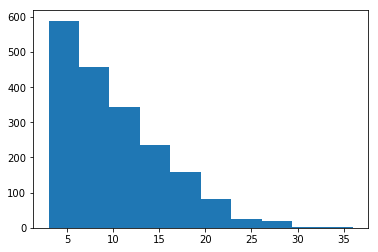

In [34]:
sizes = []
for msgsize, subdata in data0.groupby("msgsize"):
    sizes.append(subdata.size)

plt.hist(sizes)

On voit que pour de nombreuses tailles de message, on dispose de peu de mesures de latence. On choisit donc d'éliminer les tailles de message pour lesquelles on dispose de moins de 10 mesures.

In [35]:
# Extraction des plus petits temps de transmission à taille de message donnée

tmins = []
sizes = []
for size, subdata in data0.groupby("msgsize"):
    # On ne prend que les données pour lesquelles on dispose d'au moins 10 mesures
    if subdata.size >= 10:
        tmin = min(subdata['time'])
        tmins.append(tmin)
        sizes.append(size)

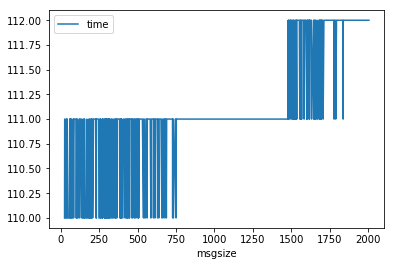

In [36]:
shorttimes = pd.DataFrame({"msgsize":sizes, "time":tmins})

shorttimes.plot("msgsize","time")

Cette modification a complètement changé l'allure des données : il n'y a plus du tout de données extrêmes, et le bruit restant est seulement dû à la quantification en valeurs entières.

Effectuons une régression linéaire, cette fois sans séparer entre "petits" et "gros" messages car cela ne paraît pas pertinent vu la faible quantité d'information qui reste.

In [37]:
lreg, rsquare = linreg(shorttimes)

# Estimation de la latence et de la capacité
# On a L = b et C = 1/a
lat = float(lreg.intercept_)
cap = 1/float(lreg.coef_)
print(f"Latence:{lat} ; capacité:{cap} ; R²={rsquare}")

Latence:110.27439846701121 ; capacité:1259.7103978295067 ; R²=0.5915851100654499


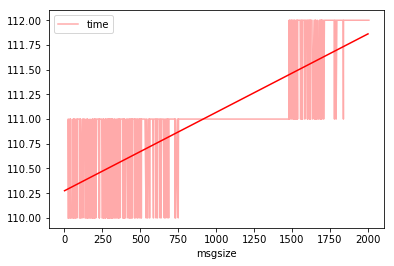

In [38]:
fig,ax = plt.subplots(1)
shorttimes.plot('msgsize','time',ax=ax,color='#ffaaaa')

# Résultat de la régression
xx = np.linspace(1,2000)
yy = lat + xx/cap
plt.plot(xx, yy, color="#ff0000")

## Conclusion

Pour résumer, voici les valeurs qu'on a obtenues à partir des plus petits temps d'échange :

### liglab2.log
```
Petits messages (<=1480 octets)
Latence:1.033 ms ; capacité:4217.8932227104215 octets/ms
Gros messages (>1480 octets)
Latence:1.743 ms ; capacité:4133.823644047976 octets/ms
```

### stackoverflow.log
```
Latence:110.27 ms ; capacité:1259.7103978295067 octets/ms
```

Ces valeurs sont valables uniquement pour des messages de taille inférieure à 2000 octets.

## Perspectives

Les extensions possibles de ce travail sont multiples.

 - On a choisi d'utiliser la plus petite durée d'échange mesurée pour estimer la performance du réseau, mais il pourrait être plus pertinent d'utiliser la médiane (à taille de message donné), ou un autre quantile.
 - La répartition des durées d'échange n'est pas quelconque : pour les deux zones envisagées, et dans les deux jeux de données on observait que, lorsque les durées d'échange étaient supérieures à la normale, elles semblaient tout de même suivre une répartition spécifique. On pourrait s'intéresser à la modélisation de cette répartition, et à l'explication de son origine.
 - Enfin, les données portaient uniquement sur des messages de taille inférieure à 2ko. Des expériences avec des messages de plus grande taille seraient propices, d'une part pour mieux estimer la capacité du réseau, et d'autre part pour vérifier si le modèle de performance reste valable.